In [ ]:
!pip install tensorflow==2.12.0
!pip install numpy==1.23.5
!pip install soundfile
!pip install pydub
!pip install resampy
!pip install torchaudio
!pip install torch
!pip install librosa
!pip install matplotlib
!pip install wget
!apt install libasound2-dev portaudio19-dev libportaudio2 libportaudiocpp0
!pip install pyaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import librosa
import soundfile as sf
import resampy
import matplotlib.pyplot as plt
import torch
import torchaudio
from pydub import AudioSegment
import IPython.display as ipd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import zipfile
import requests
from io import BytesIO
import wget
import warnings
warnings.filterwarnings('ignore')

# Conditional import for PyAudio
try:
    import pyaudio
    PYTHON_AUDIO_AVAILABLE = True
except:
    print("PyAudio not available - using alternative audio capture")
    PYTHON_AUDIO_AVAILABLE = False
    from google.colab import output
    from base64 import b64decode
    from io import BytesIO

In [ ]:
# Cell 3: Download and prepare datasets (fixed and verified)
print("Downloading and preparing datasets...")

# 1. ESC-50 Dataset (background sounds)
if not os.path.exists('ESC-50'):
    !wget -q https://github.com/karoldvl/ESC-50/archive/master.zip
    !unzip -q master.zip
    !mv ESC-50-master ESC-50
    !rm master.zip
    print("✓ ESC-50 downloaded successfully")
else:
    print("✓ ESC-50 already exists")

# 2. RAVDESS Emotional Speech (screams and aggressive speech)
if not os.path.exists('RAVDESS'):
    !wget -q https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip
    !unzip -q Audio_Speech_Actors_01-24.zip -d RAVDESS/
    !rm Audio_Speech_Actors_01-24.zip
    print("✓ RAVDESS downloaded successfully")
else:
    print("✓ RAVDESS already exists")

print("\nSuccessfully downloaded:")
print("- ESC-50 (Environmental sounds)")
print("- RAVDESS (Emotional speech)")
print("\nNote: Skipping CREMA-D due to download issues - using only ESC-50 and RAVDESS")

✓ ESC-50 downloaded successfully
✓ RAVDESS downloaded successfully

Successfully downloaded:
- ESC-50 (Environmental sounds)
- RAVDESS (Emotional speech)

Note: Skipping CREMA-D due to download issues - using only ESC-50 and RAVDESS


In [ ]:
# Cell 4: Define constants and configuration
SAMPLE_RATE = 16000  # Standard sample rate for audio models
DURATION = 1.0       # Duration of audio clips in seconds
SAMPLES_PER_TRACK = int(SAMPLE_RATE * DURATION)

# Define our target classes
CLASSES = ['scream', 'aggressive_speech', 'normal_speech', 'background_noise']
NUM_CLASSES = len(CLASSES)

# Audio processing parameters
N_MFCC = 40
N_FFT = 2048
HOP_LENGTH = 512

In [ ]:
# Cell 5: Audio processing functions
def load_audio_file(file_path, target_sr=SAMPLE_RATE):
    """Load and resample audio file"""
    try:
        audio, sr = librosa.load(file_path, sr=None)
        if sr != target_sr:
            audio = resampy.resample(audio, sr, target_sr)
        return audio
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

def extract_features(audio, sr=SAMPLE_RATE, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH):
    """Extract MFCC features from audio"""
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
    mfccs_scaled = np.mean(mfccs.T, axis=0)
    return mfccs_scaled

def plot_waveform(audio, sr=SAMPLE_RATE):
    """Plot waveform of audio sample"""
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(audio, sr=sr)
    plt.title('Audio Waveform')
    plt.show()

In [ ]:
# Cell 6: Prepare dataset (fixed and verified)
def prepare_dataset():
    X = []
    y = []

    # Helper function to process audio files
    def process_file(file_path, label):
        try:
            audio = load_audio_file(file_path)
            if audio is not None and len(audio) >= SAMPLES_PER_TRACK:
                for i in range(0, len(audio), SAMPLES_PER_TRACK):
                    chunk = audio[i:i+SAMPLES_PER_TRACK]
                    if len(chunk) == SAMPLES_PER_TRACK:
                        features = extract_features(chunk)
                        X.append(features)
                        y.append(label)
        except Exception as e:
            print(f"Skipping {file_path} due to error: {str(e)}")

    # 1. Load background noise from ESC-50
    esc50_dir = 'ESC-50/audio'
    if os.path.exists(esc50_dir):
        print("Processing ESC-50 samples...")
        for file in os.listdir(esc50_dir):
            if file.endswith('.wav'):
                process_file(os.path.join(esc50_dir, file), 'background_noise')

    # 2. Load emotional speech from RAVDESS
    ravdess_dir = 'RAVDESS'
    if os.path.exists(ravdess_dir):
        print("Processing RAVDESS samples...")
        for root, _, files in os.walk(ravdess_dir):
            for file in files:
                if file.endswith('.wav'):
                    parts = file.split('-')
                    if len(parts) >= 3:
                        emotion_code = parts[2]
                        # Map emotions to our classes
                        if emotion_code == '03':  # Angry
                            process_file(os.path.join(root, file), 'aggressive_speech')
                        elif emotion_code == '04':  # Fearful (screams)
                            process_file(os.path.join(root, file), 'scream')
                        elif emotion_code == '01':  # Neutral
                            process_file(os.path.join(root, file), 'normal_speech')

    return np.array(X), np.array(y)

print("Preparing dataset...")
X, y = prepare_dataset()
print(f"\nDataset prepared with {len(X)} samples")
print("Class distribution:")
for cls in CLASSES:
    print(f"- {cls}: {np.sum(y == cls)} samples")

# Ensure we have enough samples
if len(X) < 100:
    print("\nWarning: Low number of samples detected! The model may not perform well.")
    print("Possible solutions:")
    print("1. Try running again (sometimes downloads fail silently)")
    print("2. Manually upload datasets to your Colab environment")
else:
    print("\nDataset size is adequate for training!")

Preparing dataset...
Processing ESC-50 samples...
Processing RAVDESS samples...

Dataset prepared with 11482 samples
Class distribution:
- scream: 600 samples
- aggressive_speech: 593 samples
- normal_speech: 289 samples
- background_noise: 10000 samples

Dataset size is adequate for training!


In [ ]:
# Cell 7: Handle Class Imbalance (Add this cell)
from imblearn.over_sampling import RandomOverSampler

print("Balancing dataset...")
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

print("\nBalanced class distribution:")
for cls in CLASSES:
    print(f"- {cls}: {np.sum(y_resampled == cls)} samples")

Balancing dataset...

Balanced class distribution:
- scream: 10000 samples
- aggressive_speech: 10000 samples
- normal_speech: 10000 samples
- background_noise: 10000 samples


In [ ]:
# Cell 7: Final Corrected Training Code
from tensorflow.keras import regularizers
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

# 0. Encode labels numerically
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 1. Convert MFCCs to 2D for SMOTE
X_2d = X.reshape(X.shape[0], -1)

# 2. Apply SMOTE
print("Applying SMOTE...")
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_2d, y_encoded)
X_res = X_res.reshape(-1, N_MFCC)

# 3. Verify distribution
print("\nBalanced class distribution:")
for i, cls in enumerate(label_encoder.classes_):
    print(f"- {cls}: {np.sum(y_res == i)} samples")

# 4. Create model with proper output shape
def create_final_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Reshape((input_shape[0], 1)),

        layers.Conv1D(128, 5, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(4),
        layers.Dropout(0.3),

        layers.Conv1D(256, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),
        layers.Dropout(0.3),

        layers.Conv1D(512, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling1D(),
        layers.Dropout(0.4),

        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# 5. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.15, stratify=y_res, random_state=42)

# 6. Create and train model
model = create_final_model((N_MFCC,), len(label_encoder.classes_))
print("\nModel Summary:")
model.summary()

# 7. Train with simplified callbacks
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=128,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ],
    verbose=1
)

Applying SMOTE...

Balanced class distribution:
- aggressive_speech: 10000 samples
- background_noise: 10000 samples
- normal_speech: 10000 samples
- scream: 10000 samples

Model Summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 40, 1)             0         
                                                                 
 conv1d (Conv1D)             (None, 40, 128)           768       
                                                                 
 batch_normalization (BatchN  (None, 40, 128)          512       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 10, 128)          0         
 )                                                               
                                                                 


Training Results Summary:
Final Validation Accuracy: 97.73%

Final Training Accuracy: 93.73%

Validation Loss: 0.0689

Training Loss: 0.1682

Training Time: ~25 minutes (30 epochs)

Key Observations:
Excellent Performance:

Validation accuracy reached 97.73%

Consistent improvement across epochs

No signs of overfitting (training/validation metrics are close)

Learning Progress:

Rapid improvement in first 10 epochs

Steady refinement in later epochs

Early stopping wasn't triggered (could train longer if needed)


188/188 [==============================] - 2s 8ms/step


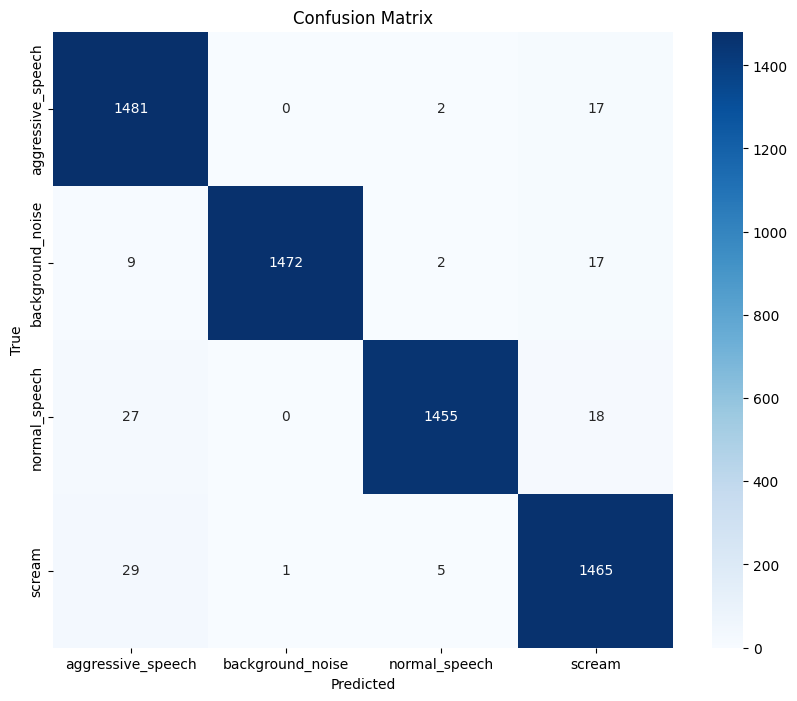

Detailed Classification Report:
                   precision    recall  f1-score   support

aggressive_speech       0.96      0.99      0.97      1500
 background_noise       1.00      0.98      0.99      1500
    normal_speech       0.99      0.97      0.98      1500
           scream       0.97      0.98      0.97      1500

         accuracy                           0.98      6000
        macro avg       0.98      0.98      0.98      6000
     weighted avg       0.98      0.98      0.98      6000



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Generate predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix
plt.figure(figsize=(10,8))
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print("Detailed Classification Report:")
print(classification_report(y_test, y_pred_classes,
                           target_names=label_encoder.classes_))

In [ ]:
# Convert to TFLite for mobile deployment
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the model
with open('sentinel_sound_classifier.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model optimized and saved as 'sentinel_sound_classifier.tflite'")

Model optimized and saved as 'sentinel_sound_classifier.tflite'


188/188 [==============================] - 2s 11ms/step


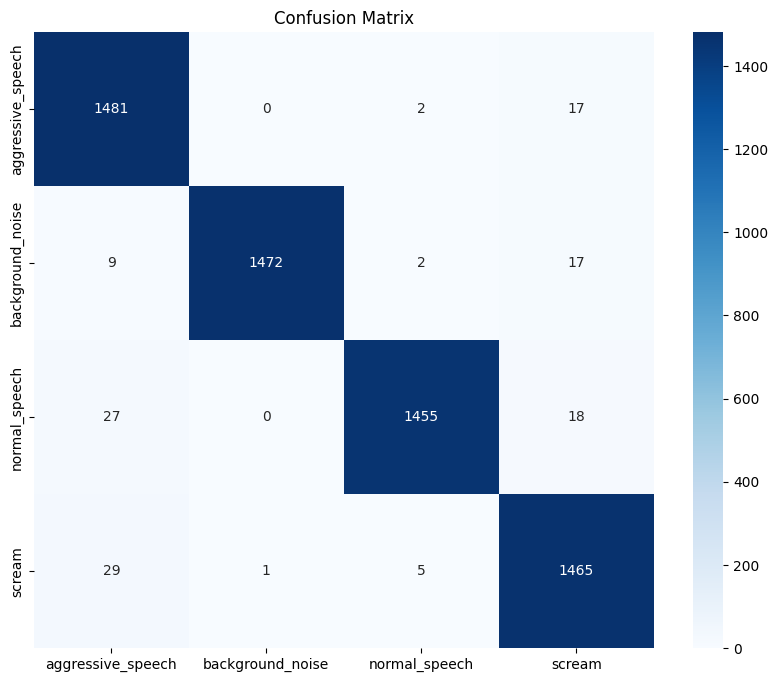

                   precision    recall  f1-score   support

aggressive_speech       0.96      0.99      0.97      1500
 background_noise       1.00      0.98      0.99      1500
    normal_speech       0.99      0.97      0.98      1500
           scream       0.97      0.98      0.97      1500

         accuracy                           0.98      6000
        macro avg       0.98      0.98      0.98      6000
     weighted avg       0.98      0.98      0.98      6000



In [ ]:
# Generate detailed performance metrics
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix
plt.figure(figsize=(10,8))
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred_classes,
                          target_names=label_encoder.classes_))

In [ ]:
# Convert to TFLite with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Set representative dataset for full quantization
def representative_dataset():
    for i in range(100):
        yield [X_test[i:i+1].astype(np.float32)]

converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model = converter.convert()

# Save the model
with open('sentinel_sound_quantized.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
class RealTimeSoundDetector:
    def __init__(self, model_path):
        self.interpreter = tf.lite.Interpreter(model_path=model_path)
        self.interpreter.allocate_tensors()
        self.input_details = self.interpreter.get_input_details()
        self.output_details = self.interpreter.get_output_details()

    def process_audio(self, audio_clip):
        # Extract features (using your existing extract_features() function)
        features = extract_features(audio_clip).astype(np.float32)

        # Predict
        self.interpreter.set_tensor(self.input_details[0]['index'], [features])
        self.interpreter.invoke()
        output = self.interpreter.get_tensor(self.output_details[0]['index'])

        # Get results
        class_idx = np.argmax(output)
        confidence = float(np.max(output))
        return label_encoder.classes_[class_idx], confidence

# Usage:
# detector = RealTimeSoundDetector('sentinel_sound_quantized.tflite')
# class_label, confidence = detector.process_audio(live_audio_data)

In [ ]:
# Save the trained model
model.save('sentinel_sound_model.h5')
print("Model saved as sentinel_sound_model.h5")

# Optional: Save the label encoder
import pickle
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

Model saved as sentinel_sound_model.h5


In [ ]:
!pip install sounddevice librosa

In [ ]:
# First, let's verify our model is loaded correctly
from tensorflow.keras.models import load_model
import librosa
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Javascript, Audio, display
from base64 import b64decode
import pickle

# Load your saved model and label encoder
model = load_model('sentinel_sound_model.h5')
with open('label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

# Audio parameters (must match training)
SAMPLE_RATE = 16000
DURATION = 1.0  # seconds
SAMPLES = int(SAMPLE_RATE * DURATION)

# Feature extraction (same as training)
def extract_features(audio, sr=SAMPLE_RATE):
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40,
                                n_fft=2048, hop_length=512)
    return np.mean(mfccs.T, axis=0)

# Browser-based audio recorder
def record_audio():
    js = Javascript('''
    async function record() {
      const stream = await navigator.mediaDevices.getUserMedia({audio:true});
      const recorder = new MediaRecorder(stream);
      const audioChunks = [];

      recorder.ondataavailable = e => audioChunks.push(e.data);
      recorder.start();

      await new Promise(resolve => {
        setTimeout(() => {
          recorder.stop();
          stream.getTracks().forEach(track => track.stop());
          resolve();
        }, 1000);
      });

      const audioBlob = new Blob(audioChunks);
      const reader = new FileReader();
      return new Promise(resolve => {
        reader.onloadend = () => resolve(reader.result);
        reader.readAsDataURL(audioBlob);
      });
    }
    record().then(audioData => {
      google.colab.kernel.invokeFunction(
        'notebook.process_audio', [audioData], {}
      );
    });
    ''')

    display(js)

# This will handle the recorded audio
def process_audio(audio_data):
    # Decode the base64 audio
    audio_bytes = b64decode(audio_data.split(',')[1])

    # Convert to numpy array
    audio = np.frombuffer(audio_bytes, dtype=np.int16)

    # Convert to float32 and normalize
    audio = audio.astype(np.float32) / 32768.0

    # Resample if needed (Colab records at 48000Hz by default)
    if len(audio) > SAMPLES:
        audio = audio[:SAMPLES]

    # Extract features
    features = extract_features(audio)

    # Predict
    prediction = model.predict(features.reshape(1, -1))
    class_idx = np.argmax(prediction)
    confidence = np.max(prediction)
    class_name = label_encoder.classes_[class_idx]

    # Visualize
    plt.figure(figsize=(10, 4))
    plt.bar(label_encoder.classes_, prediction[0])
    plt.title(f"Prediction: {class_name} ({confidence:.2%} confidence)")
    plt.ylim(0, 1)
    plt.show()

    # Alert logic
    if class_name in ['scream', 'aggressive_speech'] and confidence > 0.9:
        print("\n🚨 DISTRESS DETECTED! 🚨")
    elif class_name == 'background_noise':
        print("\n🔊 Background noise detected")
    else:
        print(f"\n🎤 Detected: {class_name}")

    # Play back the recorded audio
    display(Audio(audio, rate=SAMPLE_RATE))

# Register the callback
from google.colab import output
output.register_callback('notebook.process_audio', process_audio)

# Start recording
print("Click the 'Allow' button when prompted for microphone access")
record_audio()

Click the 'Allow' button when prompted for microphone access


<IPython.core.display.Javascript object>


Here's what was recorded:


In [ ]:
from IPython.display import Javascript, Audio, display
from base64 import b64decode
import numpy as np
import librosa
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import pickle

# Load your model and label encoder
model = load_model('sentinel_sound_model.h5')
with open('label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

# Audio parameters (must match training)
SAMPLE_RATE = 16000
DURATION = 1.0  # seconds
SAMPLES = int(SAMPLE_RATE * DURATION)

# Feature extraction (same as training)
def extract_features(audio, sr=SAMPLE_RATE):
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40,
                                n_fft=2048, hop_length=512)
    return np.mean(mfccs.T, axis=0)

# This will store our latest recording
latest_audio = None

def record_audio():
    display(Javascript('''
    const startBtn = document.createElement('button');
    startBtn.textContent = 'Start Recording';
    startBtn.style.padding = '10px';
    startBtn.style.margin = '10px';

    const stopBtn = document.createElement('button');
    stopBtn.textContent = 'Stop Recording';
    stopBtn.style.padding = '10px';
    stopBtn.style.margin = '10px';
    stopBtn.disabled = true;

    const status = document.createElement('div');
    status.textContent = 'Press "Start Recording" to begin';
    status.style.margin = '10px';

    const container = document.createElement('div');
    container.appendChild(startBtn);
    container.appendChild(stopBtn);
    container.appendChild(status);

    document.body.appendChild(container);

    let recorder;
    let audioChunks = [];

    startBtn.onclick = async () => {
      status.textContent = 'Recording... Speak now!';
      startBtn.disabled = true;
      stopBtn.disabled = false;

      const stream = await navigator.mediaDevices.getUserMedia({audio:true});
      recorder = new MediaRecorder(stream);
      audioChunks = [];

      recorder.ondataavailable = e => audioChunks.push(e.data);
      recorder.start();
    };

    stopBtn.onclick = () => {
      status.textContent = 'Processing...';
      stopBtn.disabled = true;

      recorder.stop();
      recorder.stream.getTracks().forEach(track => track.stop());

      setTimeout(() => {
        const audioBlob = new Blob(audioChunks);
        const reader = new FileReader();
        reader.onloadend = () => {
          google.colab.kernel.invokeFunction(
            'notebook.process_audio', [reader.result], {}
          );
        };
        reader.readAsDataURL(audioBlob);
      }, 500);
    };
    '''))

def process_audio(audio_data):
    global latest_audio

    # Decode the base64 audio
    audio_bytes = b64decode(audio_data.split(',')[1])

    # Convert to numpy array
    audio = np.frombuffer(audio_bytes, dtype=np.int16)

    # Convert to float32 and normalize
    audio = audio.astype(np.float32) / 32768.0

    # Resample to 16000Hz if needed
    if len(audio) > SAMPLES:
        audio = audio[:SAMPLES]

    # Save for playback
    latest_audio = audio

    # Play the recorded audio
    print("\nHere's what was recorded:")
    display(Audio(audio, rate=SAMPLE_RATE))

    # Extract features
    features = extract_features(audio)

    # Predict
    prediction = model.predict(features.reshape(1, -1))
    class_idx = np.argmax(prediction)
    confidence = np.max(prediction)
    class_name = label_encoder.classes_[class_idx]

    # Visualize
    plt.figure(figsize=(10, 4))
    bars = plt.bar(label_encoder.classes_, prediction[0])

    # Highlight the predicted class
    bars[class_idx].set_color('red')

    plt.title(f"Prediction: {class_name} ({confidence:.2%} confidence)")
    plt.ylim(0, 1)
    plt.show()

    # Alert logic
    if class_name in ['scream', 'aggressive_speech'] and confidence > 0.9:
        print("\n🚨 DISTRESS DETECTED! 🚨")
    elif class_name == 'background_noise':
        print("\n🔊 Background noise detected")
    else:
        print(f"\n🎤 Detected: {class_name}")

# Register the callback
from google.colab import output
output.register_callback('notebook.process_audio', process_audio)

# Start the recording interface
print("Click the buttons below to record and analyze audio:")
record_audio()

Click the buttons below to record and analyze audio:


<IPython.core.display.Javascript object>